# 📊🛠️ **ME03: Data Processing** 
### **Seminario I - Período 2024 II**
---

Por: 
- Andres Fonseca Galvis 
- Juan Felipe Quinto 

In [522]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pyodbc
import sqlite3
import math
import seaborn as sns
import importlib
from scipy.stats import norm
from sklearn.impute import SimpleImputer
import inspect
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
import sys
import os
import importlib

# Agregar la ruta relativa a la carpeta Data_CSV desde la carpeta actual
ruta_data_csv = os.path.abspath(os.path.join(os.getcwd(), '..', 'Data_CSV'))
sys.path.append(ruta_data_csv)

import importlib
from funciones_m import *
from funciones_eda import *

importlib.reload(funciones_m)
importlib.reload(funciones_eda)



<module 'funciones_eda' from 'c:\\Users\\quint\\OneDrive\\Documentos\\GitHub\\Seminario\\Data_CSV\\funciones_eda.py'>

---

## **Definición de Objetivo notebook**
El objetivo de este notebook es desarrollar un conjunto de datos que permita entrenar un modelo predictivo capaz de estimar los días de incumplimiento de los proveedores de materia prima importada, a partir del análisis de datos históricos. Este modelo busca optimizar la gestión de la cadena de suministro, reduciendo los tiempos improductivos ocasionados por el incumplimiento.

## **Campos Originales**

- **orden**: Número de orden de compra.
- **linea**: Línea de pedido.
- **entrega**: Entrega.
- **fecha_ingreso_inventario**: Fecha en la que el material o producto fue ingresado al inventario.
- **fecha_aproximada_necesidad**: Fecha estimada en la que se necesita el material o producto para ser utilizado en la producción.
- **dia_semana_aproximado**: Día de la semana correspondiente a la fecha aproximada de necesidad.
- **mes_aproximado**: Mes correspondiente a la fecha aproximada de necesidad.
- **año_aproximado**: Año correspondiente a la fecha aproximada de necesidad.
- **fecha_entrega_real**: Fecha en la que se recibió la entrega del material o producto, es decir, la fecha efectiva de entrega.
- **nit_proveedor**: Número de Identificación Tributaria (NIT) del proveedor que realizó la entrega.
- **CreationDate_proveedor**: Fecha de creación del registro del proveedor en el sistema.
- **cantidad**: Cantidad de material o producto ordenado.
- **pais**: País de origen del proveedor o de la entrega.
- **forma_envio**: Método de envío utilizado para entregar el material o producto.
- **unidad_de_medida/U**: Unidad de medida utilizada para la cantidad del material.
- **terminos_de_pago**: Condiciones de pago acordadas con el proveedor.
- **categoria_**: Categoría del producto o material solicitado.
- **STATUS_08**: Estado del pedido o de la entrega, que podría indicar si el pedido está en proceso, finalizado o cancelado.
- **cumplio**: Indicador que muestra si el proveedor cumplió con la fecha de entrega.
- **dias_diferencia_entrega**: Diferencia en días entre la fecha de entrega real y la fecha de necesidad aproximada, indicando si hubo retraso o si se entregó a tiempo. _(Variable a predecir)_ 

## **Métrica Calculada**

La métrica _cumplimiento_ se deriva de evaluar si las entregas se realizaron dentro del plazo acordado o si hubo retrasos. Esta métrica permite identificar patrones de cumplimiento de los proveedores y sirve como una variable categórica clave para modelar la variable `dias_diferencia_entrega`, que es la variable objetivo en este análisis.

- **Cumplimiento**: Representa si `(fecha_aproximada_necesidad - fecha_entrega_real) <= 0`, en cuyo caso se clasifica como **"CUMPLIÓ"**; de lo contrario, se clasifica como **"NO CUMPLIÓ"**. Estos valores se representan como 1 y 0, respectivamente.
    
- **Días de diferencia en la entrega**: Representa la diferencia en días entre la fecha de necesidad y la fecha de entrega real, calculada como `(fecha_aproximada_necesidad - fecha_entrega_real)`


### **ANALISIS EXPLORATORIO**

In [523]:
""" se cargan los datos alamcenados en la carpeta de datos de github"""

csv_path = os.path.join(os.getcwd(), '..', 'Data_CSV', 'data_all.csv')

# Cargar el archivo CSV
df = pd.read_csv(csv_path)
#df=df[df.cumplio==0]


- se cargan los datos alamcenados en la carpeta de datos de github.

In [524]:
datos_generales(df)
categoricos=categoricas(df)
numeric=numericas(df)

El dataframe tiene 9897 filas y 20 columnas
Las columnas categoricas son: 13
Las columnas numericas son: 7


- se indaga en la dimensionalidad de los datos.

In [525]:
resumen_inicial(df)

,columns,tipo de dato,categorias
0,orden,int64,3119
1,linea,int64,99
2,entrega,int64,9
3,fecha_ingreso_inventario,object,1275
4,fecha_aproximada_necesidad,object,1828
5,dia_semana_aproximado,object,7
6,mes_aproximado,object,12
7,año_aproximado,int64,17
8,fecha_entrega_real,object,1891
9,nit_proveedor,object,284


- tabla donde se verifica el tipo de datos y el numero de categorias por feature.

In [526]:
transfor_fecha(df,['fecha_ingreso_inventario',\
        'fecha_aproximada_necesidad','fecha_entrega_real','CreationDate_proveedor'])

- el codigo transforma tipo de columnas en tipo date.

In [527]:
duplicados(df)

la cantidad de duplicados es: 78


- se verifica el numero de datos duplicados.

In [528]:
df=df.drop_duplicates()

- se eliminan duplicados.

In [529]:
print(df['unidad_de_medida/U'].unique())
df['unidad_de_medida/U'] = df['unidad_de_medida/U'].apply(vacios)

['OZ' 'KG' 'LB' 'UD' '  ']


- esta función se encarga de cambiar los espacios en blanco de la columna 'unidad_de_medida/U' por  valores nullos.

In [530]:
df.isnull().sum()

orden                          0
linea                          0
entrega                        0
fecha_ingreso_inventario       0
fecha_aproximada_necesidad     0
dia_semana_aproximado          0
mes_aproximado                 0
año_aproximado                 0
fecha_entrega_real             0
nit_proveedor                  0
CreationDate_proveedor         0
cantidad                       0
pais                           0
forma_envio                    1
unidad_de_medida/U            23
terminos_de_pago               1
categoria_                     0
STATUS_08                      0
cumplio                        0
dias_diferencia_entrega        0
dtype: int64

- buscar valores nullos en todas las variables.

In [531]:
nullos(df).head(2)

la cantidad de nulos es: 25


,orden,linea,entrega,fecha_ingreso_inventario,fecha_aproximada_necesidad,dia_semana_aproximado,mes_aproximado,año_aproximado,fecha_entrega_real,nit_proveedor,CreationDate_proveedor,cantidad,pais,forma_envio,unidad_de_medida/U,terminos_de_pago,categoria_,STATUS_08,cumplio,dias_diferencia_entrega
767,77724705,1,1,2024-07-30,2024-07-25,Thursday,July,2024,2024-07-25,84352008,2021-08-27 09:29:43.400,1200.0,TAIWAN,AEREO,NaN,GIRO ANTICIPADO,PROGRAMA VARIOS,activo,1,0
2291,77720678,1,1,2023-06-15,2023-06-08,Thursday,June,2023,2023-06-08,611520598,2020-09-08 15:32:13.810,500.0,ESTADOS UNIDOS,AEREO,NaN,A 30 DIAS,PROGRAMA VARIOS,activo,1,0


- Esta función está diseñada para identificar y analizar los valores nulos en un DataFrame.

### **ANALITICA DESCRIPTIVA**

In [532]:
df=imputar(df)

- esta funcion rellena los valores nullos en un dataframe usando el valor mas frecuente de cada columna, utilizando la funcion de simple imputer de sklearn.

In [533]:
df_=borrar_caracteristicas(df,['orden','linea','entrega','fecha_ingreso_inventario'\
        ,'fecha_aproximada_necesidad','fecha_entrega_real','nit_proveedor',\
    'CreationDate_proveedor','unidad_de_medida/U','STATUS_08','cumplio','año_aproximado'])

In [534]:
modelo=['XGBRegressor()']
feature_importances_df=importance_1(modelo,df_)
feature_importances_df.head(4)

,Variable_Global,Importancia
3,pais,0.4
2,mes,0.2
0,categoria,0.1
1,forma,0.1


Este código realiza el entrenamiento de un modelo de aprendizaje automático `XGBRegressor`, al cual se le aplica la **importancia de variables** para indicar cuánto contribuye cada característica a la predicción.

En el proceso, se separa la variable `resultado` utilizando la función `split('_')` para obtener una variable global a partir de la unión de la columna y la combinación de las múltiples características del modelo.

In [535]:
modelo_2=['RandomForestRegressor()']
feature_importances_df_=importance_1(modelo_2,df_)
feature_importances_df_.head(4)

,Variable_Global,Importancia
0,cantidad,0.4
1,dia,0.3
2,mes,0.1


- En el análisis de **importancia de características** (_feature importance_) utilizando los modelos `XGBRegressor` y `RandomForestRegressor`, y considerando que el objetivo es entender los factores que afectan los tiempos de entrega de los proveedores, se observa que las variables **país**, **forma de envío** y **categoría de proveedor** son las más influyentes y comunes en ambos modelos. Estas variables desempeñan un papel crítico en la predicción y el análisis de tiempos de entrega, ya que están directamente relacionadas con los aspectos logísticos y operativos que determinan la rapidez y fiabilidad de las entregas.
    
- Basándonos en el análisis de importancia de las variables, el conjunto de datos se filtrará utilizando estas tres variables más influyentes: **país**, **forma de envío** y **categoría de producto**.

In [536]:
tabla__(df,'forma_envio')

,forma_envio,count,acumulado
0,AEREO,6531,66.5
1,MARITIMO,2820,95.2
2,FERREO,292,98.2
3,TERRESTRE,176,100.0


- dado que la forma de envio areo u maritimo representa alrededor del 95%  de los datos,se va centrar el analisis filtrando estas dos formas de envio.

In [537]:
tabla__(df,'pais').head(4)

,pais,count,acumulado
0,ESTADOS UNIDOS,3505,35.7
1,CHINA,3132,67.6
2,ESPAÑA,1080,78.6
3,SOUTH KOREA,637,85.1


- Los envíos desde **Estados Unidos** y **China** representan el 67.6% de los envíos totales, y al sumar **España** y **Corea del Sur**, esta cifra alcanza el 85%. Enfocar el análisis en estos cuatro países permitirá estudiar la mayoría de los patrones logísticos. Se plantea un análisis combinado entre los países **Estados Unidos** y **China**, con el fin de entender la dinámica de estos dos países, que debido a su volumen tienen un impacto mayor.

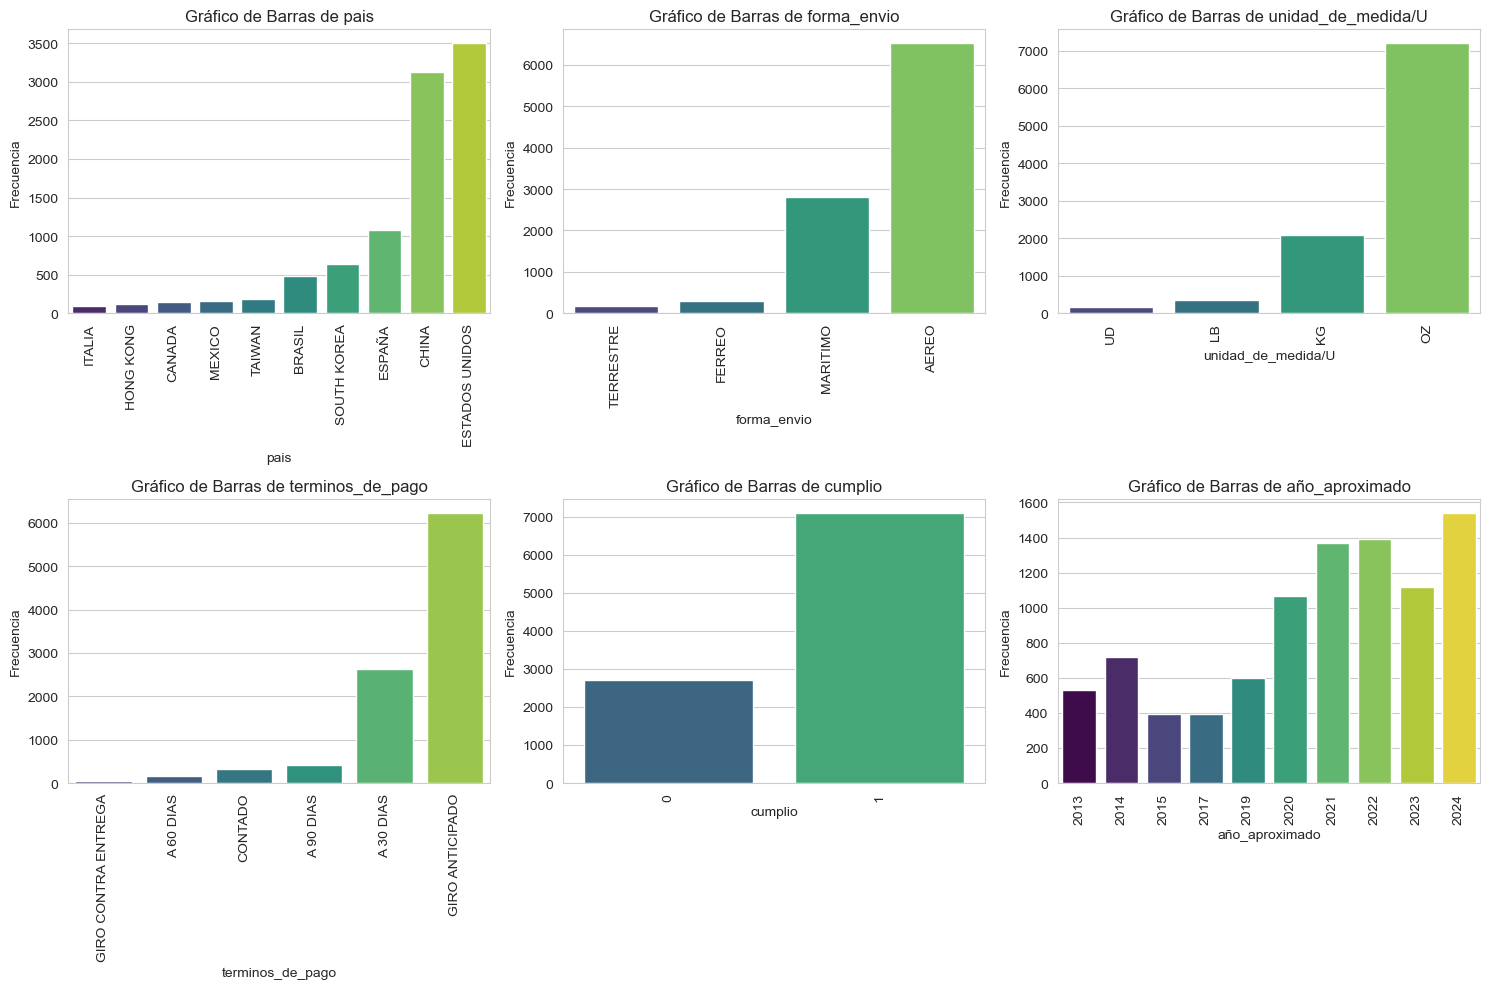

In [538]:
graficar_barras_columnas(df,['pais','forma_envio',\
    'unidad_de_medida/U',\
    'terminos_de_pago','cumplio','año_aproximado'])

In [539]:
df=borrar_caracteristicas(df,['orden','linea','entrega','fecha_ingreso_inventario'\
        ,'fecha_entrega_real','nit_proveedor',\
    'CreationDate_proveedor','STATUS_08'])

### **FILTRO DATA SET**

esta es la sección donde comenzamos a aplicar filtros para enfocar el análisis en los países con mayor impacto logístico. El primer filtro se aplica para extraer los datos específicos de **China** y **Estados Unidos**

In [540]:
#df_china_usa=df[((df['pais']=='CHINA') | (df['pais']=='ESTADOS UNIDOS')) & ((df['forma_envio']=='MARITIMO') | (df['forma_envio']=='AEREO'))]
df_china=df[df['pais']=='CHINA']
df_usa=df[df['pais']=='ESTADOS UNIDOS']

In [541]:
datos_generales(df_china)
categoricos_=categoricas(df_china)
numeric_=numericas(df_china)

El dataframe tiene 3132 filas y 12 columnas
Las columnas categoricas son: 7
Las columnas numericas son: 4


### **Análisis Univariado**
Los análisis univariados son fundamentales para entender **cada variable** individualmente, Permiten identificar **patrones, tendencias y outliers** en los datos.

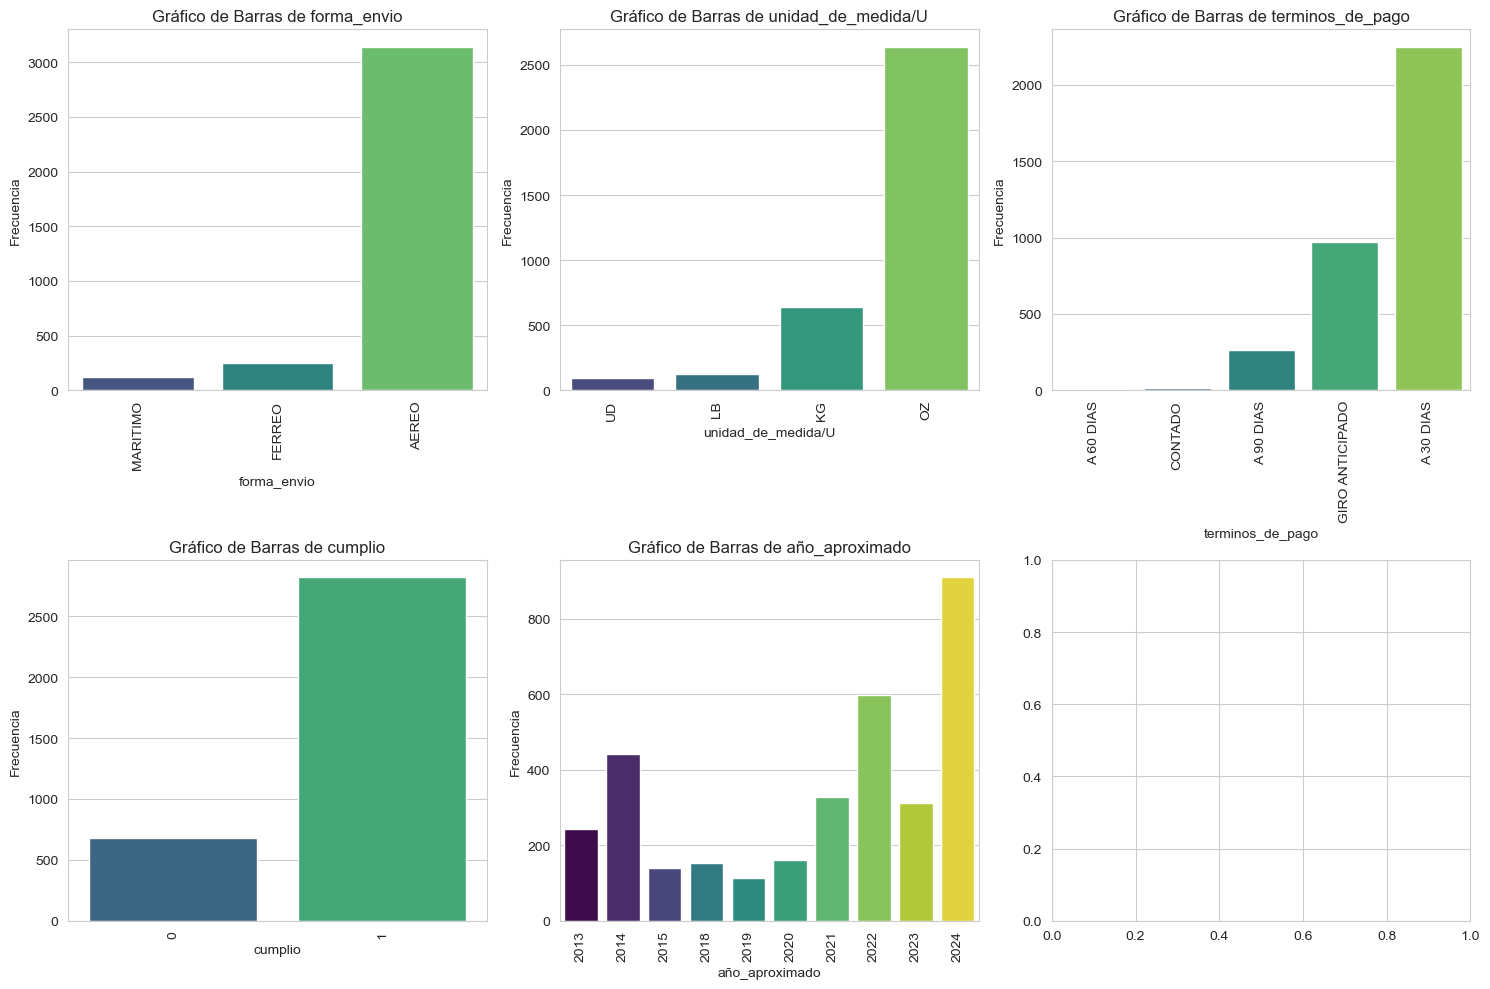

In [542]:
graficar_barras_columnas(df_usa,['forma_envio',\
    'unidad_de_medida/U',\
    'terminos_de_pago','cumplio','año_aproximado'])

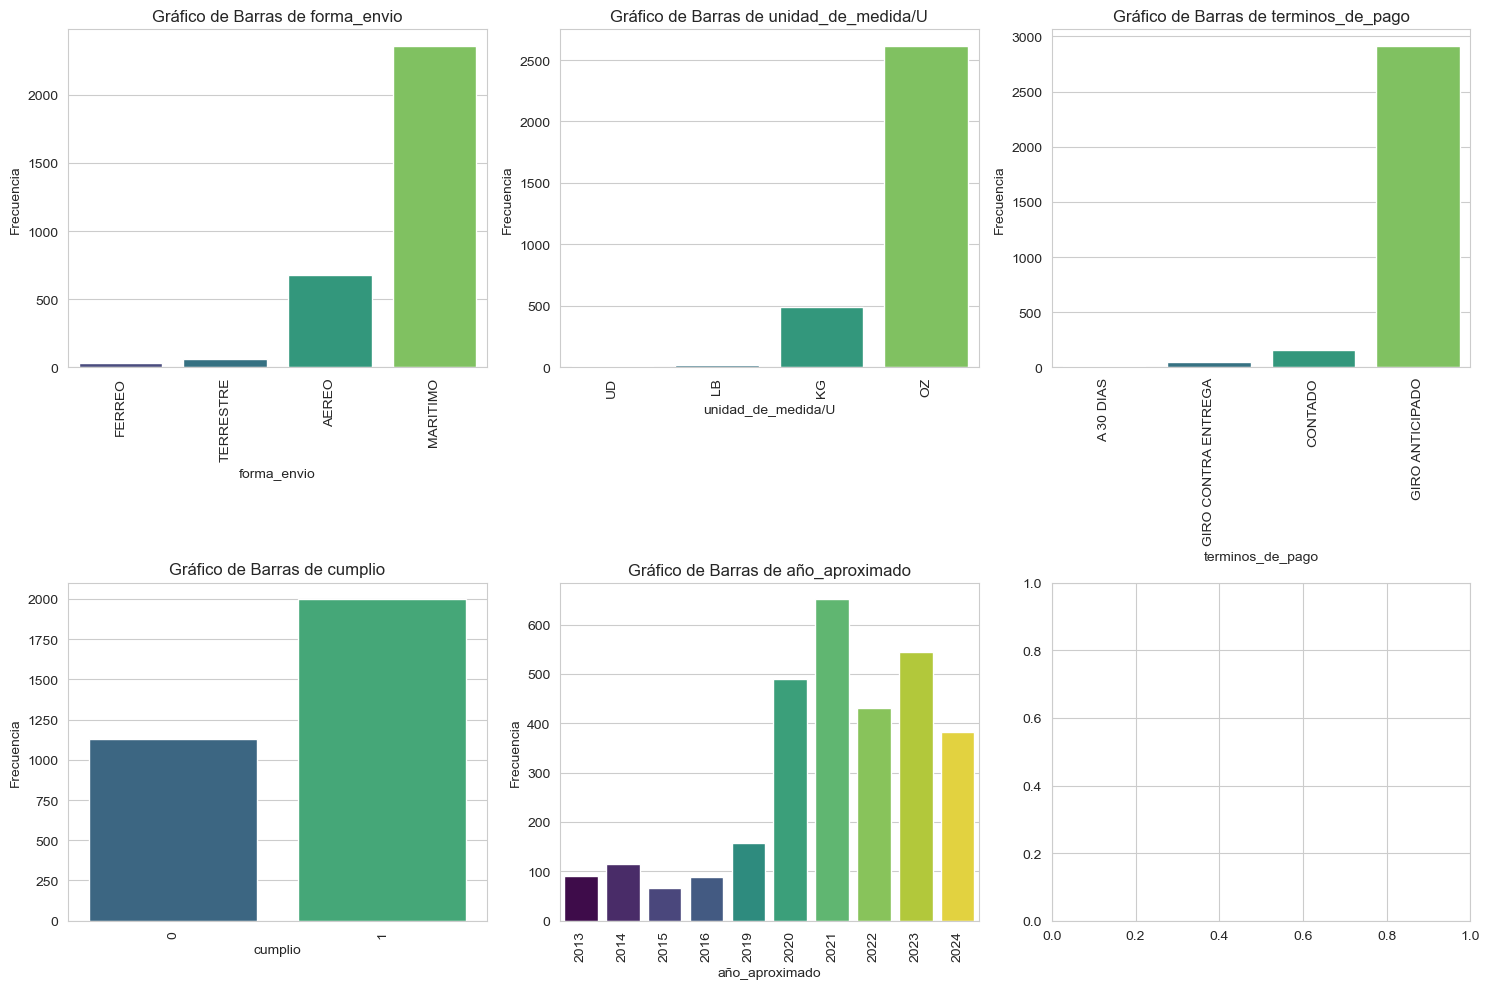

In [543]:
graficar_barras_columnas(df_china,['forma_envio',\
    'unidad_de_medida/U',\
    'terminos_de_pago','cumplio','año_aproximado'])

-  La preferencia por el **envío marítimo** sugiere que los **costos** son una consideración importante. Además, el uso de la unidad **OZ** indica un enfoque en productos de menor tamaño y peso. Por otro lado, el **pago anticipado** sugiere una política de bajo riesgo en términos financieros con los proveedores.
    
- La mayoría de los envíos desde **China** cumplen con los tiempos o requisitos establecidos, con un **63.86% de cumplimiento**. Este porcentaje sugiere que, en general, las operaciones con proveedores de China son confiables; sin embargo, el **36.14% de incumplimiento** es relativamente alto, lo cual representa un área de oportunidad.
    
- También se observó un crecimiento significativo en las importaciones desde China a partir de **2020**, seguido de una estabilización en los registros desde ese año.

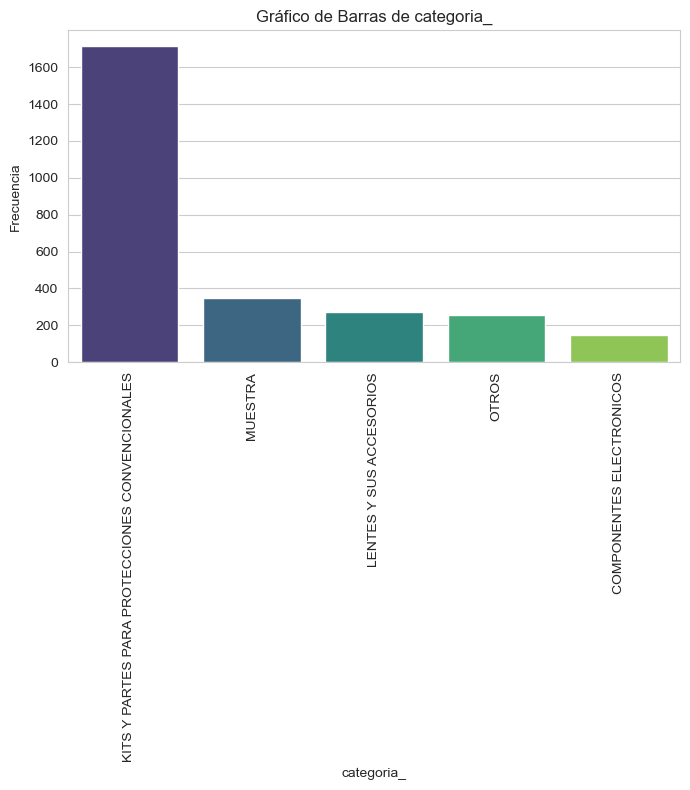

,categoria_,Frecuencia_acumulada
0,KITS Y PARTES PARA PROTECCIONES CONVENCIONALES,62.62
1,MUESTRA,75.33
2,LENTES Y SUS ACCESORIOS,85.30
3,OTROS,94.58
4,COMPONENTES ELECTRONICOS,99.99


In [544]:
tabla_(df_china,'categoria_',5)

En el grupo de categorías **"Kits y Partes para Protecciones Convencionales"**, **"Muestra"**, **"Lentes y sus Accesorios"**, **"Otros"** y **"Electrónicos"** se representa la mayor parte del total, por lo que el análisis debería priorizar el abastecimiento para estas categorías. Es importante hacer una salvedad con la categoría **Muestra**, ya que no representa material solicitado directamente para las órdenes de producción. Estas muestras son utilizadas por el área de **I+D** para experimentar en mejoras o nuevos productos.

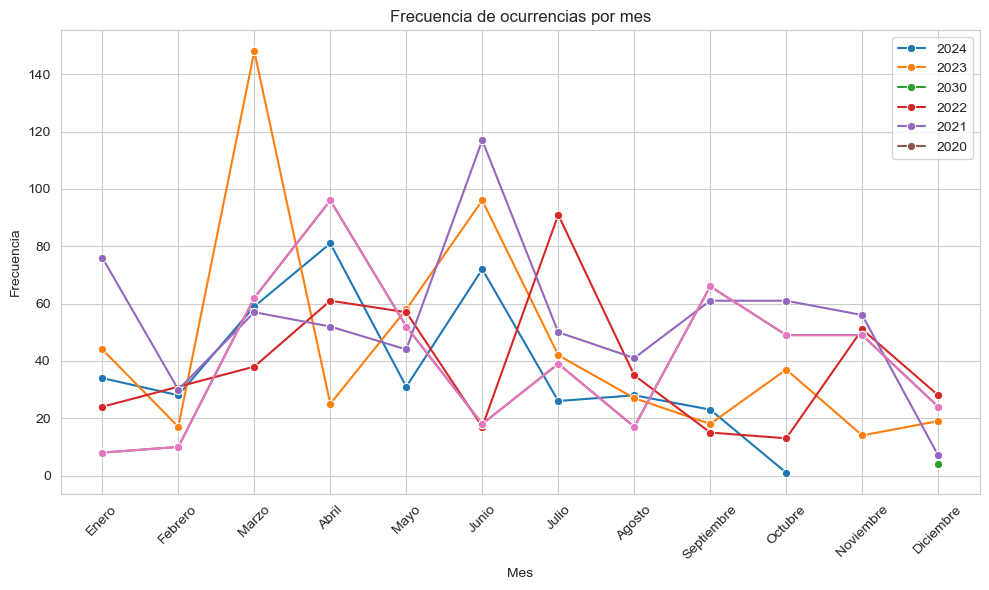

In [545]:
lineas_meses_año(df_china,'fecha_aproximada_necesidad')

- Este análisis muestra que las importaciones de materia prima desde **China** presentan cierta **estacionalidad**, con picos en ciertos meses como **marzo** y **junio**, y una menor actividad en meses como **febrero**, **octubre** y **diciembre**. Además, el año **2023** presenta un pico inusualmente alto en el mes de marzo en comparación con los otros años.
    
- Algunas propuestas para análisis posteriores incluyen separar el año **2023** para un análisis específico de este año. También es recomendable utilizar **feature engineering** para crear nuevas variables que puedan explicar de mejor forma la estacionalidad de las importaciones en el modelo.

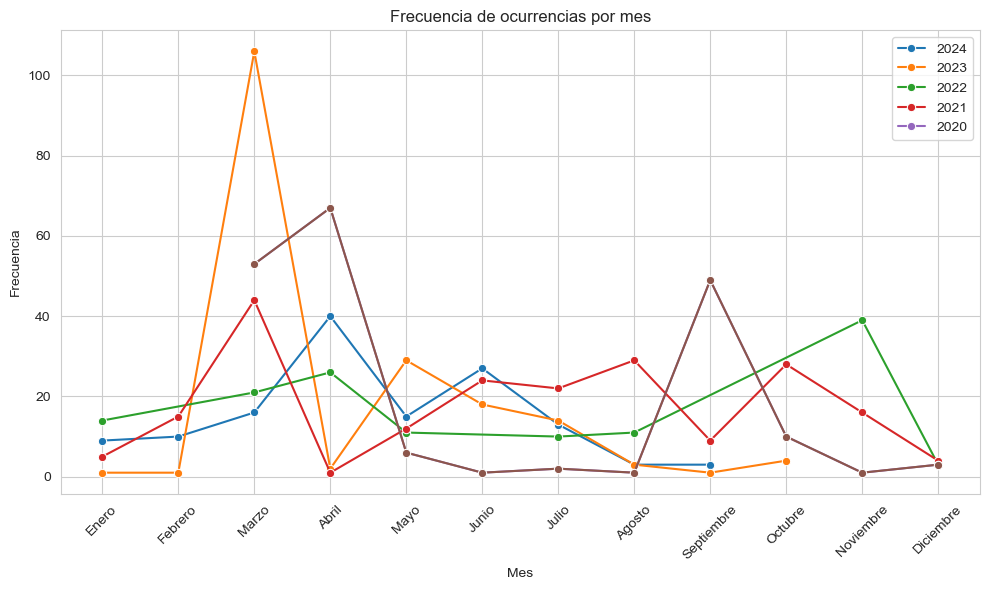

In [546]:
df_incumplio=df_china[df_china['cumplio']!=1]
lineas_meses_año(df_incumplio,'fecha_aproximada_necesidad')

- Se observan picos notables de **incumplimiento** en ciertos meses, especialmente en **marzo de 2023** y en **abril de 2020**. Sin embargo, cada año muestra una distribución diferente a lo largo de los meses. Por ejemplo, en **2020**, se presenta otro pico en **septiembre**, mientras que en **2022** y **2024** la distribución es más equilibrada, con fluctuaciones menores a lo largo del año.
    
- Algunos meses, como **junio** y **diciembre**, presentan bajas frecuencias de incumplimiento en la mayoría de los años.
    
- Se recomienda aplicar dos enfoques de modelado: uno seleccionando el mes de **marzo de 2023** y otro sin incluir este dato, para evaluar qué modelo es capaz de generalizar mejor, teniendo en cuenta este pico.

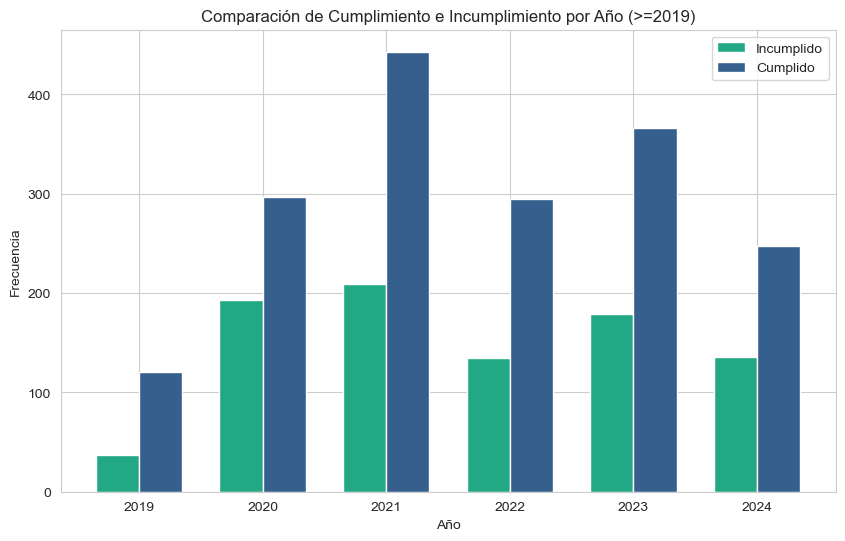

In [547]:
grafica_de_barras_compracion(df_china)

- Para el año **2021**, se observa un pico de **cumplimiento** significativamente mayor en comparación con otros años. Sin embargo, en **2020** y **2021**, la frecuencia de **incumplimiento** fue mayor en comparación con los demás años, mientras que en **2022** y **2024**, las frecuencias de incumplimiento disminuyeron.
    
- A lo largo de los años, el incumplimiento se mantiene constante, lo que sugiere que existen entregas que no se logran completar a tiempo independientemente del año.
    
- Se recomienda realizar un análisis separado para los **cumplimientos** y **incumplimientos**, ya que los factores o condiciones para ambos pueden ser distintos. Este análisis específico de los incumplimientos podría ayudar al modelo a identificar patrones concretos de los días de incumplimiento.

---
## **ANALSIS DESCRIPTIVO**

Variable `dias_diferencia_entrega`

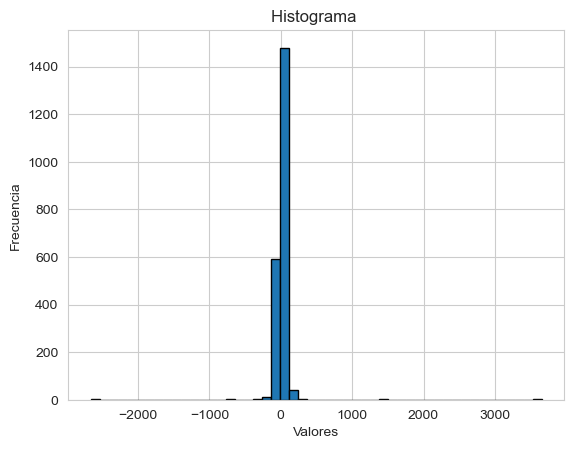

In [548]:
df_h=df_china[df_china.dias_diferencia_entrega!=0]
histograma(df_h['dias_diferencia_entrega'])

La mayoría de los valores parecen estar cerca de **cero**, lo que sugiere que la gran mayoría de los tiempos de entrega están muy próximos a la fecha programada. Sin embargo, existen **valores extremos**, tanto negativos como positivos. Los valores **negativos** indican entregas adelantadas, mientras que los **positivos** representan retrasos. La frecuencia de estos valores extremos es baja, lo cual indica que son excepciones en los datos.

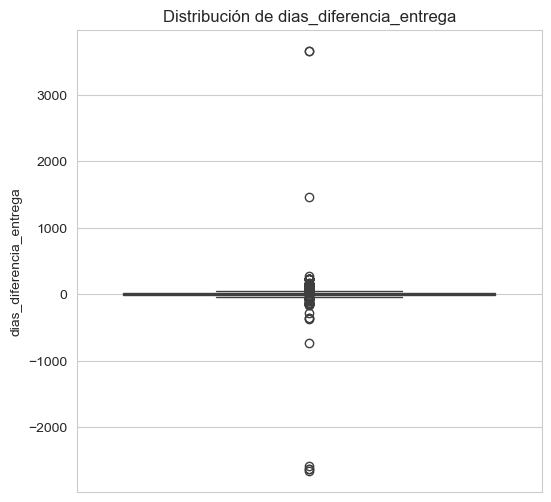

In [549]:
boxplot(df_h,'dias_diferencia_entrega')

La mayor parte de los datos se concentra alrededor de la **mediana**, que está cercana a **cero**, lo que sugiere que, en general, las entregas se realizan cerca de la fecha programada. Sin embargo, la presencia de **outliers extremos** en ambas direcciones podría estar afectando la **simetría de la distribución**, lo cual podría requerir un tratamiento especial para el manejo de outliers.

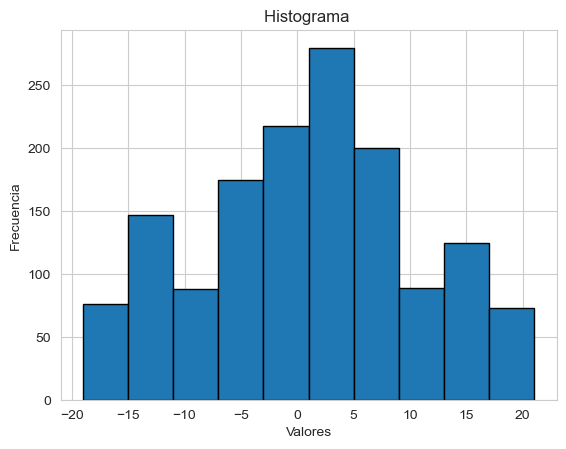

In [550]:
df_sin_outliers=eliminar_outliers_iqr(df_china,'dias_diferencia_entrega',1.5)
df_sin_outliers=df_sin_outliers[df_sin_outliers.dias_diferencia_entrega!=0]
histograma(df_sin_outliers.dias_diferencia_entrega,10)

- Tras aplicar el manejo de **outliers** mediante el método de **rango intercuartílico** y filtrar los datos con valor **cero** (entregas que llegan a tiempo según la necesidad), los datos muestran una distribución más centrada y simétrica, con una forma cercana a la **distribución normal**. Esto resulta en una distribución más controlada y centrada en la **media**.

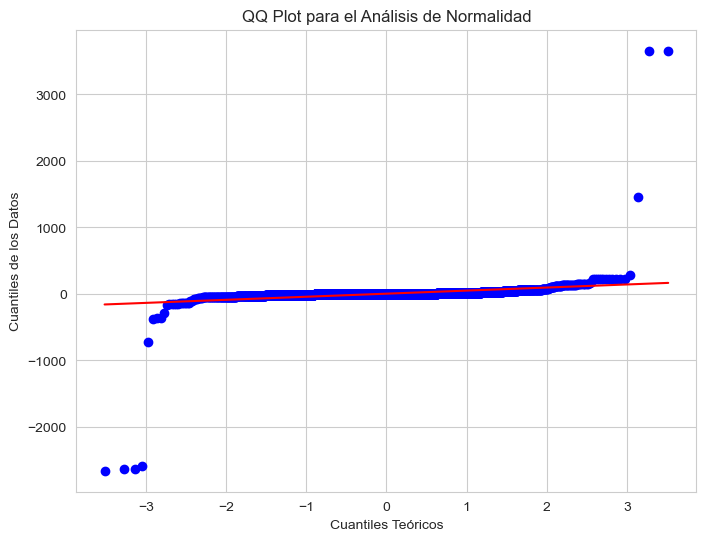

In [551]:
qq_plot(df_china.dias_diferencia_entrega)

- se observan valores extremos en ambas direcciones, ya que son puntos que estan alejados de la pendiente la cual refleja la dispersion de los datos en relacion con distribucion teorica. los valores extremos, tanto en los datos estan afectando la escala y aque no se puede ver el detalle del comportamiento.

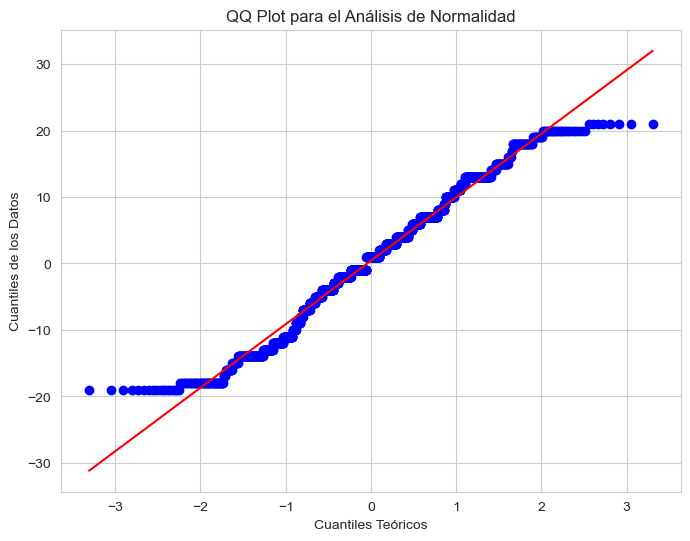

In [552]:
qq_plot(df_sin_outliers.dias_diferencia_entrega)

- aplicando los metodos de IQR outliers y el filtro de los valores cero, los dias de diferencia tienen una distribucion normal en el centro de los datos siendo una distribucion mas natural en comparacion que los datos son filtro de outliers, sin embargo en las colas los puntos no siguen perfectamente la distribucion normal, sugiriendo la posible presencia de sesgo o datos extremos en los datos ya depurados.

- si es necesario es aconsejable hacer una transformacion logaritmica o cuadrada con el fin de que los datos tengan un mejor ajuste en la normalidad.

In [553]:
shapiro_test(df_sin_outliers.dias_diferencia_entrega)

Estadístico: 0.9822044968605042
P-valor: 1.6438310131497436e-12
Los datos no tienen una distribución normal (se rechaza H0)


In [554]:
kolmogorov_smirnov_test(df_sin_outliers.dias_diferencia_entrega)

Estadístico KS: 0.4374810033339418
P-valor: 1.0962625219955114e-256
Se rechaza la hipótesis nula: los datos no siguen una distribución normal


- para ambas pruebas estadisticas de normalidad, el valor p es mucho menor al alpha de 0.05 por lo que hay evidencia para rechazar la hipotesis nula de que los datos sigan una distribucion normal. se considera para un analisis posterior usar metodos que no dependen de la normalidad de los datos como Mann-Whitney o Wilcoxon.

- tambien otro alternativa es utilizar modelos que no requieran normalidad en los datos, random forest o los metodos de boosting. 

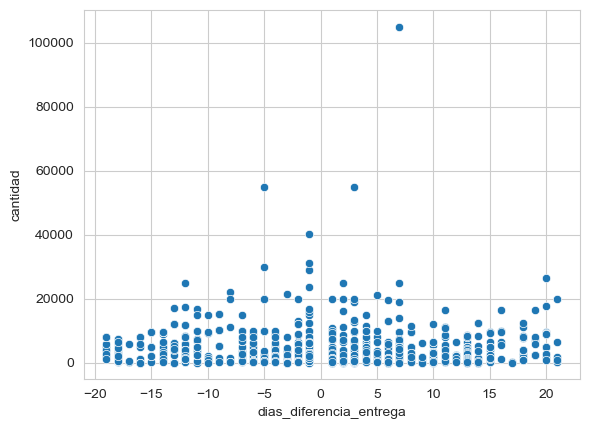

In [555]:
scater_plot(df_sin_outliers,'dias_diferencia_entrega','cantidad')

---

Variable `cantidad`

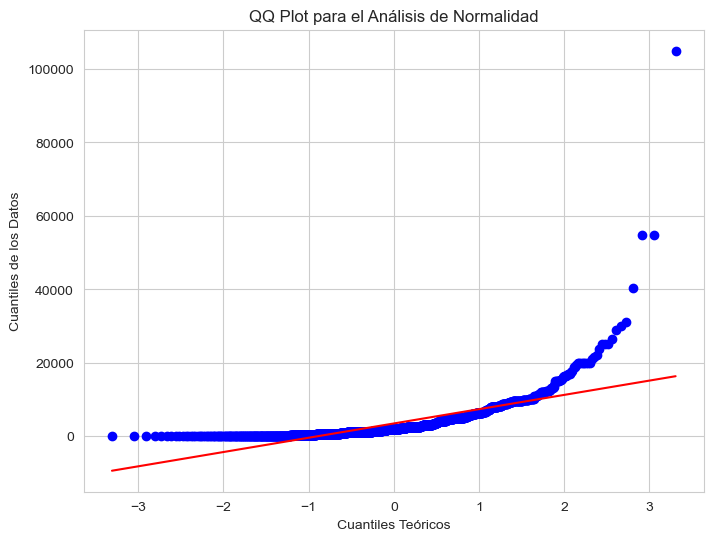

In [556]:
qq_plot(df_sin_outliers.cantidad)

- **Desviación Considerable de la Línea de Normalidad**: Los puntos se desvían de la línea roja teórica de normalidad, especialmente en los cuantiles superiores.
    
- **Presencia de Valores Atípicos**: En la cola derecha del gráfico se observa una concentración de puntos fuera de la línea esperada, lo cual indica valores atípicos significativos.

In [557]:
df_sin_outliers = eliminar_outliers_iqr(df_sin_outliers,'cantidad',1.5)

Se aplica todo el mismo el metodo de eliminacion de outliers 

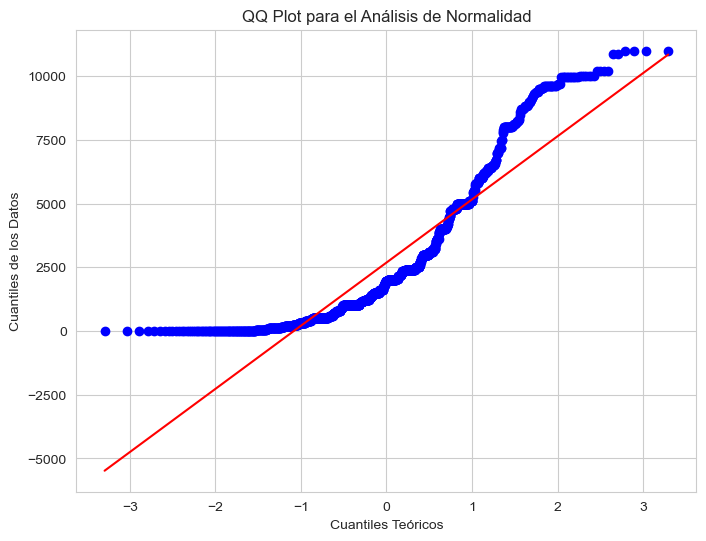

In [558]:
qq_plot(df_sin_outliers.cantidad)

El QQ Plot muestra que los puntos se desvían considerablemente de la línea roja, lo que indica que los datos no siguen una distribución normal. Esta desviación es especialmente evidente en los extremos, lo cual sugiere la presencia de valores extremos y una distribución no normal. Por lo tanto, es posible que se necesiten métodos que no asuman normalidad o una transformación de los datos para analizarlos adecuadamente.

In [559]:
shapiro_test(df_sin_outliers.cantidad)

Estadístico: 0.8481793403625488
P-valor: 1.1200367314023998e-34
Los datos no tienen una distribución normal (se rechaza H0)


In [560]:
kolmogorov_smirnov_test(df_sin_outliers.cantidad)

Estadístico KS: 0.9673110706293385
P-valor: 0.0
Se rechaza la hipótesis nula: los datos no siguen una distribución normal


- **Prueba de Shapiro-Wilk**:  
  El valor estadístico es 0.848 y el p-valor es muy pequeño (1.12e-34), lo cual indica que debemos rechazar la hipótesis nula de que los datos siguen una distribución normal. Esto significa que los datos no son normales.

- **Prueba de Kolmogorov-Smirnov**:  
  El valor del estadístico KS es 0.967 y el p-valor es 0.0, lo cual también nos lleva a rechazar la hipótesis nula. Esto refuerza la conclusión de que los datos no siguen una distribución normal.

Ambas pruebas muestran evidencia de que los datos no presentan una distribución normal, lo que sugiere considerar transformaciones o utilizar métodos que no dependan de esta suposición.


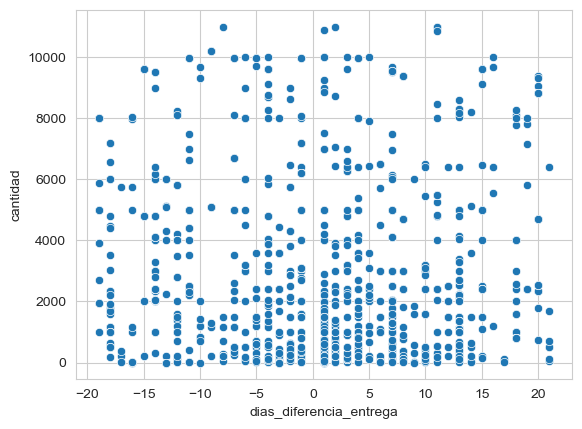

In [561]:
scater_plot(df_sin_outliers,'dias_diferencia_entrega','cantidad')

In [562]:
numerical_columns = ['cantidad', 'dias_diferencia_entrega']

In [563]:
desc_stats = df_sin_outliers[numerical_columns].describe()
print("Estadísticas descriptivas:")
print(desc_stats)

Estadísticas descriptivas:
           cantidad  dias_diferencia_entrega
count   1404.000000              1404.000000
mean    2681.707265                 0.400997
std     2686.371950                 9.639224
min        1.000000               -19.000000
25%      550.000000                -6.000000
50%     1944.000000                 1.000000
75%     4000.000000                 7.000000
max    11000.000000                21.000000


Filtramos para que solo queden los registros que cumplen

In [564]:
df_filtrado = df_sin_outliers[df_sin_outliers['dias_diferencia_entrega'] > 0]

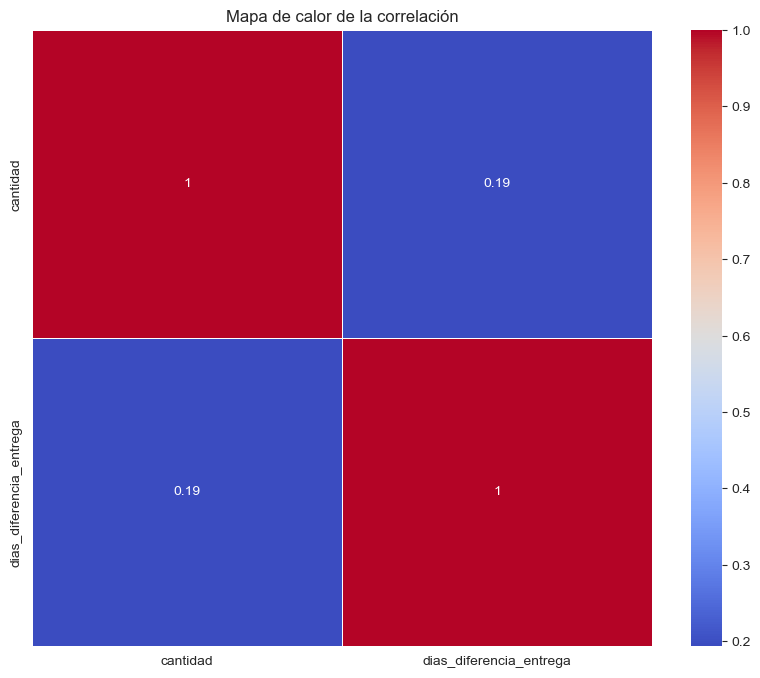

In [565]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_filtrado[numerical_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de calor de la correlación')
plt.show()

Se observa que dentro de estos filtros la variacion en días es explicada para los días de diferencia 

In [566]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 735 entries, 4 to 9791
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   fecha_aproximada_necesidad  735 non-null    datetime64[ns]
 1   dia_semana_aproximado       735 non-null    object        
 2   mes_aproximado              735 non-null    object        
 3   año_aproximado              735 non-null    int64         
 4   cantidad                    735 non-null    float64       
 5   pais                        735 non-null    object        
 6   forma_envio                 735 non-null    object        
 7   unidad_de_medida/U          735 non-null    object        
 8   terminos_de_pago            735 non-null    object        
 9   categoria_                  735 non-null    object        
 10  cumplio                     735 non-null    int64         
 11  dias_diferencia_entrega     735 non-null    int64         
dty

Nuevamente se observan valores muy altos en terminos tanto de los días como de la variable de cantidad; ahora pasamos nuavemnete analizarlos meidante pruebas de normalidad

Nuevamente visualizamos los datos e identificamos los vaolores atipicos en una  boxplot 

---


### **DATA SET DE ENTRENAMIENTO**

Una vez se identifica de forma clara que hay potencial de relacion y simplificando toda la informacion del dataset nos ponemos a disponer los datos para realizar los experiementos de Machine Learning, para ello la idea es eliminar la informacion que no es reelevante desde el punto de vista de la prediccion y las variables que se tienen 

In [567]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 735 entries, 4 to 9791
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   fecha_aproximada_necesidad  735 non-null    datetime64[ns]
 1   dia_semana_aproximado       735 non-null    object        
 2   mes_aproximado              735 non-null    object        
 3   año_aproximado              735 non-null    int64         
 4   cantidad                    735 non-null    float64       
 5   pais                        735 non-null    object        
 6   forma_envio                 735 non-null    object        
 7   unidad_de_medida/U          735 non-null    object        
 8   terminos_de_pago            735 non-null    object        
 9   categoria_                  735 non-null    object        
 10  cumplio                     735 non-null    int64         
 11  dias_diferencia_entrega     735 non-null    int64         
dty

In [568]:
# Convertir mes_aproximado a mes numérico
df_filtrado['mes_aproximado'] = pd.to_datetime(df_filtrado['mes_aproximado'], format='%B').dt.month

# Extraer el día del mes de fecha_aproximada_necesidad
df_filtrado['dia_aproximado'] = pd.to_datetime(df_filtrado['fecha_aproximada_necesidad']).dt.day


C:\Users\quint\AppData\Local\Temp\ipykernel_2832\3637648178.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['mes_aproximado'] = pd.to_datetime(df_filtrado['mes_aproximado'], format='%B').dt.month
C:\Users\quint\AppData\Local\Temp\ipykernel_2832\3637648178.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['dia_aproximado'] = pd.to_datetime(df_filtrado['fecha_aproximada_necesidad']).dt.day


In [569]:
df_filtrado = df_filtrado.drop(columns=['cumplio', 'terminos_de_pago', 'pais', 'año_aproximado', 'dia_semana_aproximado', 'fecha_aproximada_necesidad'])
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 735 entries, 4 to 9791
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mes_aproximado           735 non-null    int32  
 1   cantidad                 735 non-null    float64
 2   forma_envio              735 non-null    object 
 3   unidad_de_medida/U       735 non-null    object 
 4   categoria_               735 non-null    object 
 5   dias_diferencia_entrega  735 non-null    int64  
 6   dia_aproximado           735 non-null    int32  
dtypes: float64(1), int32(2), int64(1), object(3)
memory usage: 40.2+ KB


In [570]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Asumiendo que ya tienes el DataFrame cargado, lo llamaremos "df"
# Crearé un ejemplo ficticio ya que no tengo acceso directo a tu DataFrame original
df = df_filtrado.copy()

# Aplicar One Hot Encoding a 'categoria_' y 'unidad_de_medida/U'
encoder = OneHotEncoder(sparse=False, drop='first')  # Para evitar la multicolinealidad, eliminamos la primera categoría

encoded_features = encoder.fit_transform(df[['categoria_', 'unidad_de_medida/U']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['categoria_', 'unidad_de_medida/U']))

# Escalar las variables numéricas
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['mes_aproximado', 'cantidad', 'dias_diferencia_entrega', 'dia_aproximado']])
scaled_df = pd.DataFrame(scaled_features, columns=['mes_aproximado', 'cantidad', 'dias_diferencia_entrega', 'dia_aproximado'])

# Concatenar las características escaladas y las codificadas
df_processed = pd.concat([scaled_df, encoded_df], axis=1)

c:\Users\quint\anaconda3\envs\DataScience\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [571]:
# Separar los datos en un 80% para entrenamiento y un 20% para prueba
train_df, test_df = train_test_split(df_processed, test_size=0.2, random_state=42)

In [572]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588 entries, 135 to 102
Data columns (total 20 columns):
 #   Column                                                                                                               Non-Null Count  Dtype  
---  ------                                                                                                               --------------  -----  
 0   mes_aproximado                                                                                                       588 non-null    float64
 1   cantidad                                                                                                             588 non-null    float64
 2   dias_diferencia_entrega                                                                                              588 non-null    float64
 3   dia_aproximado                                                                                                       588 non-null    float64
 4   categoria__BOBINA